In [4]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

import numpy as np
import matplotlib.pyplot as plt

from sOED import SOED
from sOED import ADPsOED
from sOED.utils import *

def linear_model(stage, theta, d, xp=None):
    """
    Linear model function G(theta, d) = theta * d

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.
    xp : np.ndarray of size (n_sample or 1, n_phys_state)
         , optional(default=None)
        The physical state.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the linear model.
    """
    global count
    count += max(len(theta), len(d))
    return theta * d

def reward_fun(stage, xb, xp, d, y):
    """
    Non-KL-divergence based reward function g_k(x_k, d_k, y_k)
    
    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    xb : numpy.ndarray of size (n_grid ** n_param, n_param + 1)
        Grid discritization of the belief state.
    xp : np.ndarray of size (n_phys_state)
        The physical state.
    d : np.ndarray of size (n_design)
        The design variable.
    y : np.ndarray of size (n_obs)
        The observation.

    Returns
    -------
    A float which is the reward.
    """
    if stage < n_stage:
        return 0
    else:
        dx = xb[1, 0] - xb[0, 0]
        mean = (xb[:, 1] * xb[:, 0]).sum() * dx
        var = (xb[:, 1] * xb[:, 0] ** 2).sum() * dx - mean ** 2
        return -2 * (np.log(var) - np.log(2)) ** 2
    
# For a linear model with normal prior and additive Gaussian noise,
# the posterior is also a normal distribution.
# This function updates the mean and std after observing new data y 
# under design d.
def update_mean_std(loc, scale, noise_scale, d, y):
    loc_new = ((y * d * scale ** 2 + loc * noise_scale ** 2) 
               / (d ** 2 * scale ** 2 + noise_scale ** 2))
    scale_new = np.sqrt(scale ** 2 * noise_scale ** 2 
                        / (d**2 * scale ** 2 + noise_scale ** 2))
    return loc_new, scale_new

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
n_stage = 2 # Number of stages.
n_param = 1 # Number of parameters.
n_design = 1 # Number of design variables.
n_obs = 1 # Number of observations.

prior_type = "normal" # "normal" for normal dist, "uniform" for uniform dist.
prior_loc = 0 # mean for normal, lower bound for uniform.
prior_scale = 3 # std for normal, range for uniform.
prior_info = [(prior_type, prior_loc, prior_scale),]

design_bounds = [(0.1, 3.0),] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 1
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

# Number of grid points on each dimension of parameter space to store PDFs.
n_grid = 50

# Method to sample posterior samples, could be "Rejection" or "MCMC", default
# is "MCMC".
post_rvs_method = "Rejection"

# Number of basic features. Basic features include
#    * mean
#    * log(var)
#    * var
#    * log(m4)
n_basic_feature = 2
# Number of degrees for the polynomial combinations of features.
n_degree = 2

# Random state could be eith an integer or None.
random_state = 2021

In [4]:
soed = ADPsOED(model_fun=linear_model,
               n_stage=n_stage,
               n_param=n_param,
               n_design=n_design,
               n_obs=n_obs,
               prior_info=prior_info,
               design_bounds=design_bounds,
               noise_info=noise_info,
               reward_fun=reward_fun,
               n_grid=n_grid,
               post_rvs_method=post_rvs_method,
               random_state=random_state,
               n_basic_feature=n_basic_feature,
               n_degree=n_degree)

In [5]:
model_evals = 0

In [6]:
# First update.
count = 0
soed.soed(1, 1000)
model_evals += count
print("\nForward model evaluations: ", model_evals)

Update Level 0
Start Exploration
******************************
Start Approximate Value Iteration
******************************

End of SOED

Forward model evaluations:  525277400


In [7]:
# First assesment.
soed.asses(10000)

Start Assesment
******************************
Averaged total reward:  0.7754


0.7754385920612894

In [8]:
# Second update.
count = 0
soed.soed(1, 1000)
model_evals += count
print("\nForward model evaluations: ", model_evals)

Update Level 1
Start Exploration
******************************
Start Exploitation
******************************
Averaged total reward:  0.7542
Start Approximate Value Iteration
******************************

End of SOED

Forward model evaluations:  1708433600


In [9]:
# Second assesment.
soed.asses(10000)

Start Assesment
******************************
Averaged total reward:  0.7673


0.7672603732893807

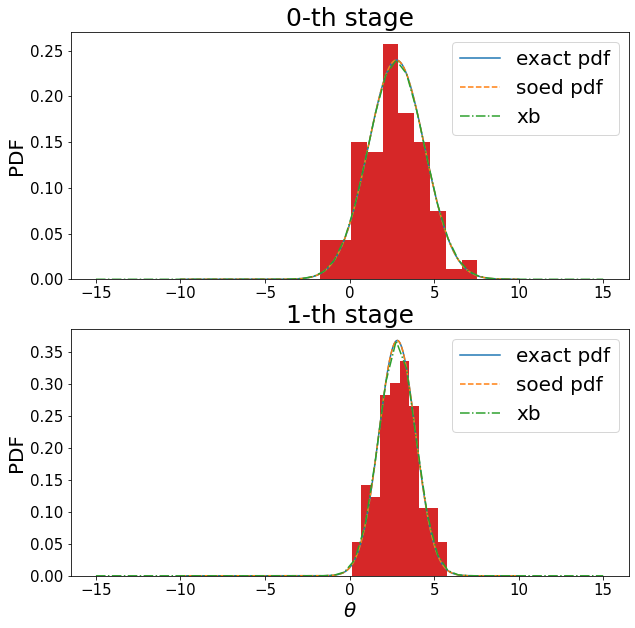

In [363]:
# Check whether post_rvs and get_xb are working well.
d_hist = np.array([[0.5], [0.7]])
y_hist = np.array([[2], [2]])
theta_grid = np.linspace(-10, 10, 1001)
dtheta = theta_grid[1] - theta_grid[0]
loc = prior_loc
scale = prior_scale
xb = None
xp = None
reward_hist = []

plt.figure(figsize=(10, 10))
for i in range(n_stage):
    reward_hist.append(soed.get_reward(i, xb, d=d_hist[i], y=y_hist[i]))
    loc, scale = update_mean_std(loc, scale, noise_base_scale, 
                                 d_hist[i], y_hist[i])
    exact_pdf = norm_pdf(theta_grid.reshape(-1, n_param), loc, scale )
    soed_pdf = soed.post_pdf(theta_grid.reshape(-1, n_param), 
                             stage=0,
                             d_hist=d_hist[0:i + 1],
                             y_hist=y_hist[0:i + 1])
    soed_pdf /= soed_pdf.sum() * dtheta
    post_samples = soed.post_rvs(100, 
                                 d_hist=d_hist[0:i + 1],
                                 y_hist=y_hist[0:i + 1],
                                 use_MCMC=False)
#     xb = soed.xb_f(xb,
#                    stage=i,
#                    d=d_hist[i],
#                    y=y_hist[i])    
    xb = soed.get_xb(None,
                     stage=0,
                     d_hist=d_hist[0:i+1],
                     y_hist=y_hist[0:i+1])
    
    plt.subplot(2, 1, i + 1)
    plt.plot(theta_grid, exact_pdf, label='exact pdf')
    plt.plot(theta_grid, soed_pdf, '--', label='soed pdf')
    plt.plot(xb[:, 0], xb[:, 1], '-.', label='xb')
    plt.hist(post_samples, density=True)
    if i == 1: plt.xlabel('$\\theta$', fontsize=20)
    plt.ylabel('PDF', fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title("{}-th stage".format(i), fontsize=25)
reward_hist.append(soed.get_reward(n_stage, xb, d=None, y=None))
total_reward, reward_hist_2 = soed.get_total_reward(d_hist, y_hist, True)